# Machine Learning Model For Predictin F1 Races Outcomes

### READIND AND PREPARING DATA

In [1]:
# run model for predict f1 races
#imports 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss, mean_squared_error

In [2]:
import optuna
print(optuna.__version__)

4.5.0


c:\Users\Sylwia\miniconda3\envs\mt_python_3_13_2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# odczyt w pliku danych thesis_f1_final_model.csv
data = pd.read_csv('../../datasets/thesis_final_model_f1_data.csv')
data.head()

,driver_number,broadcast_name,country_code_x,year,session_name,date_start,time_start,date_end,time_end,gmt_offset,...,num_yellow_flags,num_double_yellow_flags,penalty_seconds,air_temp_mean,track_temp_mean,humidity_mean,pressure_mean,is_rainfall,wind_speed_mean,final_position
0,1,M VERSTAPPEN,NED,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.09,31.79,57.79,1010.93,0,1.77,2
1,2,L SARGEANT,USA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.09,31.79,57.79,1010.93,0,1.77,16
2,4,L NORRIS,GBR,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.09,31.79,57.79,1010.93,0,1.77,17
3,10,P GASLY,FRA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.09,31.79,57.79,1010.93,0,1.77,9
4,11,S PEREZ,MEX,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.09,31.79,57.79,1010.93,0,1.77,1


In [5]:
# after baku 2145, 31
data.shape

(2154, 31)

In [6]:
X = data.drop(columns=['final_position'])
y = data['final_position']

In [7]:
X.head()

,driver_number,broadcast_name,country_code_x,year,session_name,date_start,time_start,date_end,time_end,gmt_offset,...,num_safety_car_deployed,num_yellow_flags,num_double_yellow_flags,penalty_seconds,air_temp_mean,track_temp_mean,humidity_mean,pressure_mean,is_rainfall,wind_speed_mean
0,1,M VERSTAPPEN,NED,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.09,31.79,57.79,1010.93,0,1.77
1,2,L SARGEANT,USA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.09,31.79,57.79,1010.93,0,1.77
2,4,L NORRIS,GBR,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.09,31.79,57.79,1010.93,0,1.77
3,10,P GASLY,FRA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.09,31.79,57.79,1010.93,0,1.77
4,11,S PEREZ,MEX,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.09,31.79,57.79,1010.93,0,1.77


In [8]:
y.head

<bound method NDFrame.head of 0        2
1       16
2       17
3        9
4        1
        ..
2149     3
2150     1
2151     1
2152    19
2153    19
Name: final_position, Length: 2154, dtype: int64>

In [9]:
def categorize_position(pos):
    if pos == 1:
        return 'winner'
    elif pos in [2, 3]:
        return 'top3'
    elif 4 <= pos <= 10:
        return 'points'
    else:
        return 'no_points'

In [10]:
# y to categorize final position
y = y.apply(categorize_position)
y.head()


0         top3
1    no_points
2    no_points
3       points
4       winner
Name: final_position, dtype: object

In [11]:
print("Unikalne kategorie przed kodowaniem:", y.unique())

Unikalne kategorie przed kodowaniem: ['top3' 'no_points' 'points' 'winner']


In [12]:
#change name final_position to final_position_category
y.rename('final_position_category', inplace=True)

0            top3
1       no_points
2       no_points
3          points
4          winner
          ...    
2149         top3
2150       winner
2151       winner
2152    no_points
2153    no_points
Name: final_position_category, Length: 2154, dtype: object

In [13]:
# wyswitel informacje o zbiorze danych
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

#wyswietl cechy
print("Features in X:", X.columns.tolist())
# wyswietl unikalne kategorie pozycji
print("Unique position categories in y:", y.unique())
print(X.dtypes)

Shape of X: (2154, 30)
Shape of y: (2154,)
Features in X: ['driver_number', 'broadcast_name', 'country_code_x', 'year', 'session_name', 'date_start', 'time_start', 'date_end', 'time_end', 'gmt_offset', 'starting_position', 'wins_before', 'pit_stops_count', 'avg_pit_stop_duration', 'qualifying_position_y', 'num_stints', 'used_soft', 'used_medium', 'used_hard', 'num_red_flags', 'num_safety_car_deployed', 'num_yellow_flags', 'num_double_yellow_flags', 'penalty_seconds', 'air_temp_mean', 'track_temp_mean', 'humidity_mean', 'pressure_mean', 'is_rainfall', 'wind_speed_mean']
Unique position categories in y: ['top3' 'no_points' 'points' 'winner']
driver_number                int64
broadcast_name              object
country_code_x              object
year                         int64
session_name                object
date_start                  object
time_start                  object
date_end                    object
time_end                    object
gmt_offset                  object
st

In [14]:
# usuniecie driver number bo to jeest numer dla kierowcy
X = X.drop(columns=['driver_number'])
X.head()

,broadcast_name,country_code_x,year,session_name,date_start,time_start,date_end,time_end,gmt_offset,starting_position,...,num_safety_car_deployed,num_yellow_flags,num_double_yellow_flags,penalty_seconds,air_temp_mean,track_temp_mean,humidity_mean,pressure_mean,is_rainfall,wind_speed_mean
0,M VERSTAPPEN,NED,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,15,...,1,3,2,0,26.09,31.79,57.79,1010.93,0,1.77
1,L SARGEANT,USA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,20,...,1,3,2,0,26.09,31.79,57.79,1010.93,0,1.77
2,L NORRIS,GBR,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,19,...,1,3,2,0,26.09,31.79,57.79,1010.93,0,1.77
3,P GASLY,FRA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,9,...,1,3,2,0,26.09,31.79,57.79,1010.93,0,1.77
4,S PEREZ,MEX,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,1,...,1,3,2,0,26.09,31.79,57.79,1010.93,0,1.77


In [15]:
#change name from country_code_x to country_code
X = X.rename(columns={'country_code_x': 'country_code'})

# change name from qualifying_position_y to qualifying_position

In [16]:
# change country_code_x to country_code
X = X.rename(columns={'country_code_x': 'country_code'})
# change qualifying_position_y to qualifying_position
X = X.rename(columns={'qualifying_position_y': 'qualifying_position'})

In [17]:
# encode data in X and scale it
from sklearn.preprocessing import LabelEncoder, StandardScaler

for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])



In [18]:
#split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

### PREPARING MODEL

In [20]:
# compute specificity   
def compute_specificity(conf_mat):
    specificity = []
    for i in range(conf_mat.shape[0]):
        TP = conf_mat[i, i]
        FP = conf_mat[:, i].sum() - TP
        FN = conf_mat[i, :].sum() - TP
        TN = conf_mat.sum() - (TP + FP + FN)
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity.append(spec)
    return specificity

In [21]:
# hyperparameter tuning with Optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import compute_sample_weight
from sklearn.preprocessing import label_binarize

def objective(trial, kfolds, X_train, y_train, X_valid, y_valid):
    # random forest
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 150)
    rf_max_depth = trial.suggest_int("rf_max_depth", 3, 15)

    # gradient boosting
    gb_n_estimators = trial.suggest_int("gb_n_estimators", 50, 150)
    gb_learning_rate = trial.suggest_float("gb_learning_rate", 0.01, 0.3)
    gb_max_depth = trial.suggest_int("gb_max_depth", 2, 10)

    # SVM
    svm_C = trial.suggest_float("svm_C", 0.1, 10.0, log=True)
    svm_kernel = trial.suggest_categorical("svm_kernel", ["linear", "rbf"])

    # models to ensemble
    clf_rf = RandomForestClassifier(n_estimators=rf_n_estimators, 
                                    max_depth=rf_max_depth, 
                                    random_state=42,
                                    n_jobs=-1)
    
    clf_gb = GradientBoostingClassifier(n_estimators=gb_n_estimators, 
                                        learning_rate=gb_learning_rate,
                                        max_depth=gb_max_depth, 
                                        random_state=42)
    
    clf_svm = SVC(C=svm_C, 
                  kernel=svm_kernel, 
                  probability=True, 
                  random_state=42) ####

    le = LabelEncoder()
    le.fit(y_train)  

    # encode labels using the fitted label encoder 'le'
    y_train_enc = le.transform(y_train)
    y_valid_enc = le.transform(y_valid)

    class_labels = le.classes_

    # cross-validation setup
    kf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)

    # lists to store metrics for each fold
    acc_list, prec_list, rec_list, f1_list, spec_list = [], [], [], [], []
    mse_list, rmse_list, logloss_list = [], [], []
    
    # PR-AUC lists
    pr_auc_macro_list, pr_auc_weighted_list = [], []

    # new metrics lists
    prec_macro_list, prec_weighted_list = [], []
    rec_macro_list, rec_weighted_list = [], []
    f1_macro_list, f1_weighted_list = [], []

    # globally summed confusion matrix
    conf_mat_sum = np.zeros((len(np.unique(y_train_enc)), len(np.unique(y_train_enc))), dtype=int)

    # cross-validation loop
    for train_index, test_index in kf.split(X_train, y_train_enc):
        X_tr, X_te = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tr, y_te = y_train_enc[train_index], y_train_enc[test_index]

        # sample_weight dla GB
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_tr)

        # ensemble predictions
        ensemble = VotingClassifier(
            estimators=[('rf', clf_rf), ('gb', clf_gb), ('svm', clf_svm)],
            voting='soft'
        )
        # dodanie skalowania
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_te_s = scaler.transform(X_te)

        ensemble.fit(X_tr_s, y_tr, sample_weight=sample_weights)
        y_pred_cv = ensemble.predict(X_te_s)
        y_proba_cv = ensemble.predict_proba(X_te_s)

        conf_mat_cv = confusion_matrix(y_te, y_pred_cv)
        conf_mat_sum += conf_mat_cv  # each fold summed to global confusion matrix

        acc_list.append(accuracy_score(y_te, y_pred_cv))
        prec_list.append(precision_score(y_te, y_pred_cv, average="micro", zero_division=0))
        rec_list.append(recall_score(y_te, y_pred_cv, average="micro", zero_division=0))
        f1_list.append(f1_score(y_te, y_pred_cv, average="micro", zero_division=0))
        auc_list = []

        # new metrics calculations
        prec_macro_list.append(precision_score(y_te, y_pred_cv, average="macro", zero_division=0))
        prec_weighted_list.append(precision_score(y_te, y_pred_cv, average="weighted", zero_division=0))

        rec_macro_list.append(recall_score(y_te, y_pred_cv, average="macro", zero_division=0))
        rec_weighted_list.append(recall_score(y_te, y_pred_cv, average="weighted", zero_division=0))

        f1_macro_list.append(f1_score(y_te, y_pred_cv, average="macro", zero_division=0))
        f1_weighted_list.append(f1_score(y_te, y_pred_cv, average="weighted", zero_division=0))

        spec_cv = np.mean(compute_specificity(conf_mat_cv))
        spec_list.append(spec_cv)

        mse_list.append(mean_squared_error(y_te, y_pred_cv))
        rmse_list.append(np.sqrt(mse_list[-1]))
        logloss_list.append(log_loss(y_te, y_proba_cv))

        # PR-AUC calculations
        y_te_bin = label_binarize(y_te, classes=np.arange(len(class_labels)))
        pr_auc_macro_list.append(average_precision_score(y_te_bin, y_proba_cv, average="macro"))
        pr_auc_weighted_list.append(average_precision_score(y_te_bin, y_proba_cv, average="weighted"))

    # average and std of metrics across folds
    acc, acc_std = np.mean(acc_list), np.std(acc_list, ddof=0)
    prec, prec_std = np.mean(prec_list), np.std(prec_list, ddof=0)
    rec, rec_std = np.mean(rec_list), np.std(rec_list, ddof=0)
    f1, f1_std = np.mean(f1_list), np.std(f1_list, ddof=0)
    spec, spec_std = np.mean(spec_list), np.std(spec_list, ddof=0)

    mse, mse_std = np.mean(mse_list), np.std(mse_list, ddof=0)
    rmse, rmse_std = np.mean(rmse_list), np.std(rmse_list, ddof=0)
    logloss, logloss_std = np.mean(logloss_list), np.std(logloss_list, ddof=0)

    # PR-AUC averages and stds
    pr_auc_macro = np.mean(pr_auc_macro_list)
    pr_auc_macro_std = np.std(pr_auc_macro_list, ddof=0)
    pr_auc_weighted = np.mean(pr_auc_weighted_list)
    pr_auc_weighted_std = np.std(pr_auc_weighted_list, ddof=0)

    # new metrics averages and stds
    prec_macro, prec_macro_std = np.mean(prec_macro_list), np.std(prec_macro_list, ddof=0)
    rec_macro, rec_macro_std = np.mean(rec_macro_list), np.std(rec_macro_list, ddof=0)
    f1_macro, f1_macro_std = np.mean(f1_macro_list), np.std(f1_macro_list, ddof=0)

    # set metrics to return 
    trial.set_user_attr("accuracy", acc)
    trial.set_user_attr("accuracy_std", acc_std)
    trial.set_user_attr("precision", prec)
    trial.set_user_attr("precision_std", prec_std)
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("recall_std", rec_std)
    trial.set_user_attr("f1_score", f1)
    trial.set_user_attr("f1_std", f1_std)
    trial.set_user_attr("specificity_avg", spec)
    trial.set_user_attr("specificity_std", spec_std)

    trial.set_user_attr("mse", mse)
    trial.set_user_attr("mse_std", mse_std)
    trial.set_user_attr("rmse", rmse)
    trial.set_user_attr("rmse_std", rmse_std)
    trial.set_user_attr("logloss", logloss)
    trial.set_user_attr("logloss_std", logloss_std)

    # set new metrics to return
    trial.set_user_attr("precision_macro", prec_macro)
    trial.set_user_attr("precision_macro_std", prec_macro_std)

    trial.set_user_attr("recall_macro", rec_macro)
    trial.set_user_attr("recall_macro_std", rec_macro_std)

    trial.set_user_attr("f1_macro", f1_macro)
    trial.set_user_attr("f1_macro_std", f1_macro_std)

    # save confusion matrix
    trial.set_user_attr("confusion_matrix", conf_mat_sum.tolist())

    trial.set_user_attr("class_labels", class_labels)

    # PR-AUC attributes
    trial.set_user_attr("pr_auc_macro", pr_auc_macro)
    trial.set_user_attr("pr_auc_macro_std", pr_auc_macro_std)
    trial.set_user_attr("pr_auc_weighted", pr_auc_weighted)
    trial.set_user_attr("pr_auc_weighted_std", pr_auc_weighted_std)

    # return metric to optimize
    return f1_macro  # or acc if you are optimizing accuracy


In [22]:
def show_best_parameters_and_metrics(study):
    best_trial = study.best_trial
    best_params = best_trial.params

    print("🎯 Najlepsze hiperparametry:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    # print("--- Mikro ---")
    # print(f"F1-score (micro): {best_trial.user_attrs['f1_score']:.4f} ± {best_trial.user_attrs['f1_std']:.4f}")
    # print(f"Accuracy: {best_trial.user_attrs['accuracy']:.4f} ± {best_trial.user_attrs['accuracy_std']:.4f}")
    # print(f"Precision (micro): {best_trial.user_attrs['precision']:.4f} ± {best_trial.user_attrs['precision_std']:.4f}")
    # print(f"Recall / Sensitivity (micro): {best_trial.user_attrs['recall']:.4f} ± {best_trial.user_attrs['recall_std']:.4f}")

    # print("\n--- Makro ---")
    # print(f"F1-score (macro): {best_trial.user_attrs['f1_macro']:.4f} ± {best_trial.user_attrs['f1_macro_std']:.4f}")
    # print(f"Precision (macro): {best_trial.user_attrs['precision_macro']:.4f} ± {best_trial.user_attrs['precision_macro_std']:.4f}")
    # print(f"Recall / Sensitivity (macro): {best_trial.user_attrs['recall_macro']:.4f} ± {best_trial.user_attrs['recall_macro_std']:.4f}")

    print("\n📊 Metryki najlepszej próby:")
    print(f"F1-score (macro): {best_trial.user_attrs['f1_macro']:.4f} ± {best_trial.user_attrs['f1_macro_std']:.4f}")
    print(f"Precision (macro): {best_trial.user_attrs['precision_macro']:.4f} ± {best_trial.user_attrs['precision_macro_std']:.4f}")
    print(f"Recall / Sensitivity (macro): {best_trial.user_attrs['recall_macro']:.4f} ± {best_trial.user_attrs['recall_macro_std']:.4f}")
    print(f"Specificity (avg): {best_trial.user_attrs['specificity_avg']:.4f} ± {best_trial.user_attrs['specificity_std']:.4f}")
    print(f"Accuracy: {best_trial.user_attrs['accuracy']:.4f} ± {best_trial.user_attrs['accuracy_std']:.4f}")
    
    print(f"PR-AUC (macro): {best_trial.user_attrs['pr_auc_macro']:.4f} ± {best_trial.user_attrs['pr_auc_macro_std']:.4f}")
    print(f"PR-AUC (weighted): {best_trial.user_attrs['pr_auc_weighted']:.4f} ± {best_trial.user_attrs['pr_auc_weighted_std']:.4f}")

    print("\n🧮 Confusion Matrix:")
    print(np.array(best_trial.user_attrs["confusion_matrix"]))


In [23]:
def get_best_ensemble(best_params):
    clf_rf = RandomForestClassifier(
        n_estimators=best_params['rf_n_estimators'],
        max_depth=best_params['rf_max_depth'],
        random_state=42,
        n_jobs=-1
    )
    clf_gb = GradientBoostingClassifier(
        n_estimators=best_params['gb_n_estimators'],
        learning_rate=best_params['gb_learning_rate'],
        max_depth=best_params['gb_max_depth'],
        random_state=42
    )
    clf_svm = SVC(
        C=best_params['svm_C'],
        kernel=best_params['svm_kernel'],
        probability=True,
        random_state=42
    )
    ensemble = VotingClassifier(
        estimators=[('rf', clf_rf), ('gb', clf_gb), ('svm', clf_svm)],
        voting='soft'
    )
    return ensemble

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def show_confusion_matrix(study):
    """Funkcja do wyświetlania tylko macierzy pomyłek"""
    best_trial = study.best_trial
    
    # Confusion Matrix
    confusion_matrix_sum = np.array(best_trial.user_attrs["confusion_matrix"])
    class_labels = best_trial.user_attrs["class_labels"]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_sum, 
                                display_labels=class_labels)
    disp.plot(ax=ax, cmap='Reds', values_format='d')
    ax.set_title("Sumaryczna macierz pomyłek (cross-validation)", fontsize=14)
    plt.tight_layout()
    plt.show()



In [51]:
def show_pr_auc_plot(study, X_train, y_train, X_valid, y_valid):
    """Funkcja do wyświetlania wykresu PR-AUC dla każdej klasy"""
    best_trial = study.best_trial
    best_params = best_trial.params

    # Tworzenie najlepszego modelu i trenowanie
    best_ensemble = get_best_ensemble(best_params)

    # Enkodowanie etykiet
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_valid_enc = le.transform(y_valid)

    # Skalowanie danych
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_valid_s = scaler.transform(X_valid)

    # Trenowanie modelu
    best_ensemble.fit(X_train_s, y_train_enc)
    y_valid_proba = best_ensemble.predict_proba(X_valid_s)

    # Binaryzacja etykiet
    from sklearn.preprocessing import label_binarize
    n_classes = len(le.classes_)
    y_valid_bin = label_binarize(y_valid_enc, classes=range(n_classes))

    # Wykres Precision-Recall
    plt.figure(figsize=(10, 10))
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    if n_classes == 2:
        y_valid_bin = y_valid_bin.ravel()
        y_valid_proba_class = y_valid_proba[:, 1]
        precision, recall, _ = precision_recall_curve(y_valid_bin, y_valid_proba_class)
        pr_auc = average_precision_score(y_valid_bin, y_valid_proba_class)
        plt.plot(recall, precision, color='blue', lw=2,
                 label=f'{le.classes_[1]} (PR-AUC = {pr_auc:.3f})')
    else:
        for i, class_name in enumerate(le.classes_):
            precision, recall, _ = precision_recall_curve(y_valid_bin[:, i], y_valid_proba[:, i])
            pr_auc = average_precision_score(y_valid_bin[:, i], y_valid_proba[:, i])
            plt.plot(recall, precision, color=colors[i % len(colors)], lw=2,
                     label=f'{class_name} (PR-AUC = {pr_auc:.3f})')

    plt.xlabel('Recall (Czułość)', fontsize=12)
    plt.ylabel('Precision (Precyzja)', fontsize=12)
    #plt.title('Krzywe Precision-Recall (PR-AUC)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1.1])
    plt.ylim([0, 1.1])
    plt.show()


In [26]:
from sklearn.metrics import average_precision_score

### RUN MODEL AND EVALUATE RESULTS

In [27]:
# run the optimization
study = optuna.create_study(direction="maximize")
#trials = 50, kfolds = 5
study.optimize(lambda trial: objective(trial, kfolds=5, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid), n_trials=50)

[I 2025-10-04 19:02:42,655] A new study created in memory with name: no-name-198a8b84-55b8-4cae-8895-1b8a31ceb316
[I 2025-10-04 19:02:53,282] Trial 0 finished with value: 0.6890817863336663 and parameters: {'rf_n_estimators': 119, 'rf_max_depth': 8, 'gb_n_estimators': 76, 'gb_learning_rate': 0.082125123911572, 'gb_max_depth': 5, 'svm_C': 0.3165722038890765, 'svm_kernel': 'linear'}. Best is trial 0 with value: 0.6890817863336663.
[I 2025-10-04 19:03:15,647] Trial 1 finished with value: 0.6311555171134886 and parameters: {'rf_n_estimators': 149, 'rf_max_depth': 4, 'gb_n_estimators': 131, 'gb_learning_rate': 0.012929157309646737, 'gb_max_depth': 5, 'svm_C': 3.484315584300279, 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.6890817863336663.
[I 2025-10-04 19:03:38,869] Trial 2 finished with value: 0.6960886372005985 and parameters: {'rf_n_estimators': 73, 'rf_max_depth': 9, 'gb_n_estimators': 105, 'gb_learning_rate': 0.09271122843009913, 'gb_max_depth': 6, 'svm_C': 1.4183956361240875, 

In [28]:
show_best_parameters_and_metrics(study)

🎯 Najlepsze hiperparametry:
rf_n_estimators: 83
rf_max_depth: 14
gb_n_estimators: 100
gb_learning_rate: 0.2453820862237886
gb_max_depth: 10
svm_C: 4.379808311947197
svm_kernel: linear

📊 Metryki najlepszej próby:
F1-score (macro): 0.7203 ± 0.0192
Precision (macro): 0.7588 ± 0.0259
Recall / Sensitivity (macro): 0.6973 ± 0.0258
Specificity (avg): 0.9155 ± 0.0106
Accuracy: 0.7903 ± 0.0214
PR-AUC (macro): 0.7660 ± 0.0259
PR-AUC (weighted): 0.8373 ± 0.0222

🧮 Confusion Matrix:
[[659  79  10   3]
 [100 401  25   3]
 [  6  50  87   8]
 [  3  17  12  44]]


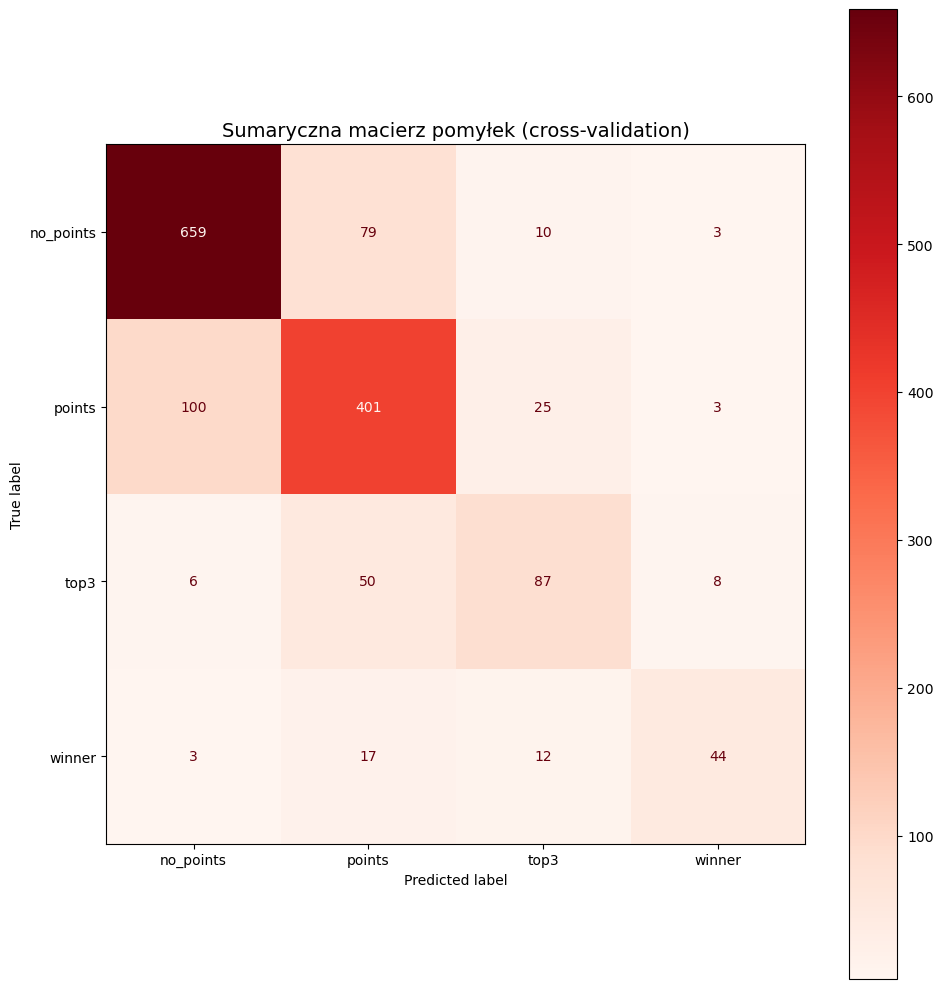

In [29]:
show_confusion_matrix(study)

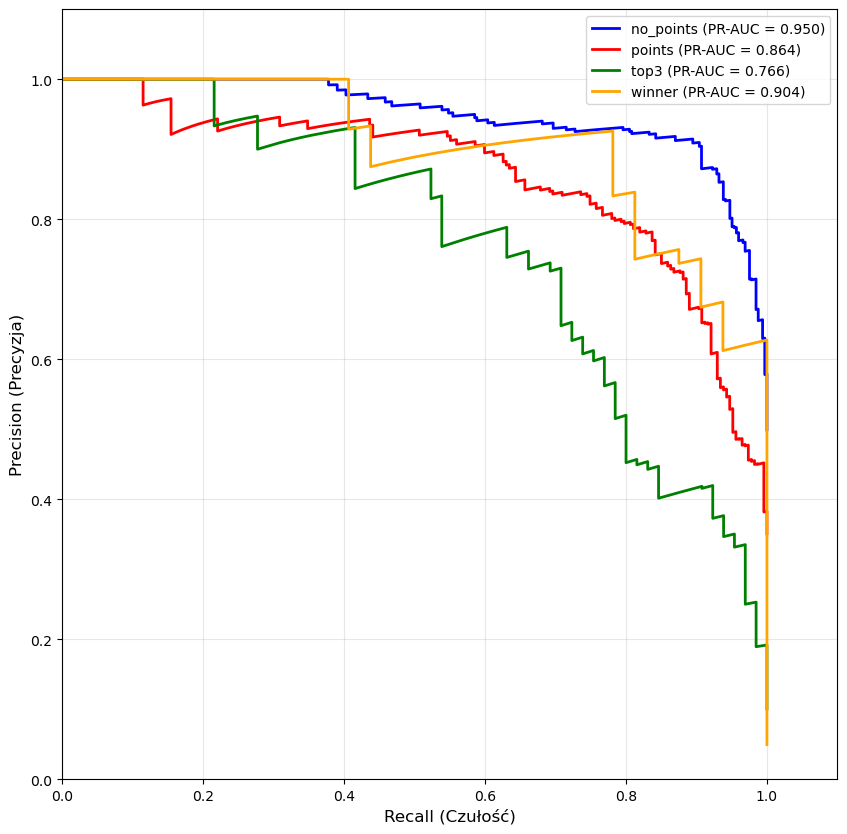

In [52]:
show_pr_auc_plot(study, X_train, y_train, X_valid, y_valid)

In [31]:
def show_feature_importance(study, X_train, y_train, feature_names):
    """Funkcja do wyświetlania ważności cech dla najlepszego modelu"""
    best_trial = study.best_trial
    best_params = best_trial.params
    
    # Tworzenie najlepszego modelu
    best_ensemble = get_best_ensemble(best_params)
    
    # Enkodowanie etykiet
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    
    # Trenowanie modelu
    best_ensemble.fit(X_train, y_train_enc)
    
    # Zbieranie ważności cech z każdego klasyfikatora
    rf_importance = best_ensemble.estimators_[0].feature_importances_  # Random Forest
    gb_importance = best_ensemble.estimators_[1].feature_importances_  # Gradient Boosting
    
    # SVM nie ma feature_importances_, więc pomijamy go lub używamy coefficients dla linear kernel
    
    # Średnia ważność z RF i GB
    avg_importance = (rf_importance + gb_importance) / 2
    
    # Tworzenie DataFrame dla lepszego wyświetlania
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Random_Forest': rf_importance,
        'Gradient_Boosting': gb_importance,
        'Average': avg_importance
    }).sort_values('Average', ascending=False)
    
    # Wykres 1: Średnia ważność cech
    plt.figure(figsize=(10, 10))
    top_features = importance_df.head(15)  # Top 15 cech
    plt.barh(range(len(top_features)), top_features['Average'], color='firebrick')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Średnia ważność cechy')
    #plt.title('Top 15 najważniejszych cech (średnia z Random Forest i Gradient Boosting)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Wykres 2: Random Forest
    plt.figure(figsize=(10, 10))
    rf_top = importance_df.head(15) # Top 15 cech
    plt.barh(range(len(rf_top)), rf_top['Random_Forest'], color='forestgreen')
    plt.yticks(range(len(rf_top)), rf_top['Feature'])
    plt.xlabel('Ważność cechy w modelu Random Forest')
    #plt.title('Top 15 cech - Random Forest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Wykres 3: Gradient Boosting
    plt.figure(figsize=(10, 10))
    gb_top = importance_df.head(15)
    plt.barh(range(len(gb_top)), gb_top['Gradient_Boosting'], color='darkorange')
    plt.yticks(range(len(gb_top)), gb_top['Feature'])
    plt.xlabel('Ważność cechy w modelu Gradient Boosting')
    #plt.title('Top 15 cech - Gradient Boosting')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Wykres 4: Porównanie top 10 cech
    plt.figure(figsize=(10, 10))
    top10 = importance_df.head(10)
    x = np.arange(len(top10))
    width = 0.35

    plt.bar(x - width/2, top10['Random_Forest'], width, label='Random Forest', color='forestgreen')
    plt.bar(x + width/2, top10['Gradient_Boosting'], width, label='Gradient Boosting', color='darkorange')

    plt.xlabel('Cechy')
    plt.ylabel('Ważność')
    #plt.title('Porównanie top 10 cech')
    plt.xticks(x, top10['Feature'], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Wyświetlenie tabeli z ważnościami
    print("\n📈 Wszystkie cechy wraz z ich ważnościami:")
    print(importance_df.round(4))
    
    return importance_df

In [32]:
def show_feature_importance_selected(study, X_train, y_train, feature_names):
    """Funkcja do wyświetlania ważności cech dla najlepszego modelu z wyselekcjonowanymi cechami"""
    best_trial = study.best_trial
    best_params = best_trial.params
    
    # Tworzenie najlepszego modelu
    best_ensemble = get_best_ensemble(best_params)
    
    # Enkodowanie etykiet
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    
    # Trenowanie modelu
    best_ensemble.fit(X_train, y_train_enc)
    
    # Zbieranie ważności cech z każdego klasyfikatora
    rf_importance = best_ensemble.estimators_[0].feature_importances_  # Random Forest
    gb_importance = best_ensemble.estimators_[1].feature_importances_  # Gradient Boosting
    
    # SVM nie ma feature_importances_, więc pomijamy go lub używamy coefficients dla linear kernel
    
    # Średnia ważność z RF i GB
    avg_importance = (rf_importance + gb_importance) / 2
    
    # Tworzenie DataFrame dla lepszego wyświetlania
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Random_Forest': rf_importance,
        'Gradient_Boosting': gb_importance,
        'Average': avg_importance
    }).sort_values('Average', ascending=False)
    
    # Wykres 1: Średnia ważność cech
    plt.figure(figsize=(10, 10))
    top_features = importance_df.head(10)  # Top 10 cech
    plt.barh(range(len(top_features)), top_features['Average'], color='firebrick')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Średnia ważność cechy')
    #plt.title('Top 10 najważniejszych cech (średnia z Random Forest i Gradient Boosting)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Wykres 2: Random Forest
    plt.figure(figsize=(10, 10))
    rf_top = importance_df.head(10) # Top 10 cech
    plt.barh(range(len(rf_top)), rf_top['Random_Forest'], color='forestgreen')
    plt.yticks(range(len(rf_top)), rf_top['Feature'])
    plt.xlabel('Ważność cechy w modelu Random Forest')
    #plt.title('Top 10 cech - Random Forest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Wykres 3: Gradient Boosting
    plt.figure(figsize=(10, 10))
    gb_top = importance_df.head(10) # Top 10 cech
    plt.barh(range(len(gb_top)), gb_top['Gradient_Boosting'], color='darkorange')
    plt.yticks(range(len(gb_top)), gb_top['Feature'])
    plt.xlabel('Ważność cechy w modelu Gradient Boosting')
    #plt.title('Top 10 cech - Gradient Boosting')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Wykres 4: Porównanie top 10 cech
    plt.figure(figsize=(10, 10))
    top10 = importance_df.head(10)
    x = np.arange(len(top10))
    width = 0.35

    plt.bar(x - width/2, top10['Random_Forest'], width, label='Random Forest', color='forestgreen')
    plt.bar(x + width/2, top10['Gradient_Boosting'], width, label='Gradient Boosting', color='darkorange')
    
    plt.xlabel('Cechy')
    plt.ylabel('Ważność')
    #plt.title('Porównanie top 10 cech')
    plt.xticks(x, top10['Feature'], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Wyświetlenie tabeli z ważnościami
    print("\n📈 Cechy wraz z ich waznosciami:")
    print(importance_df.round(4))
    
    return importance_df

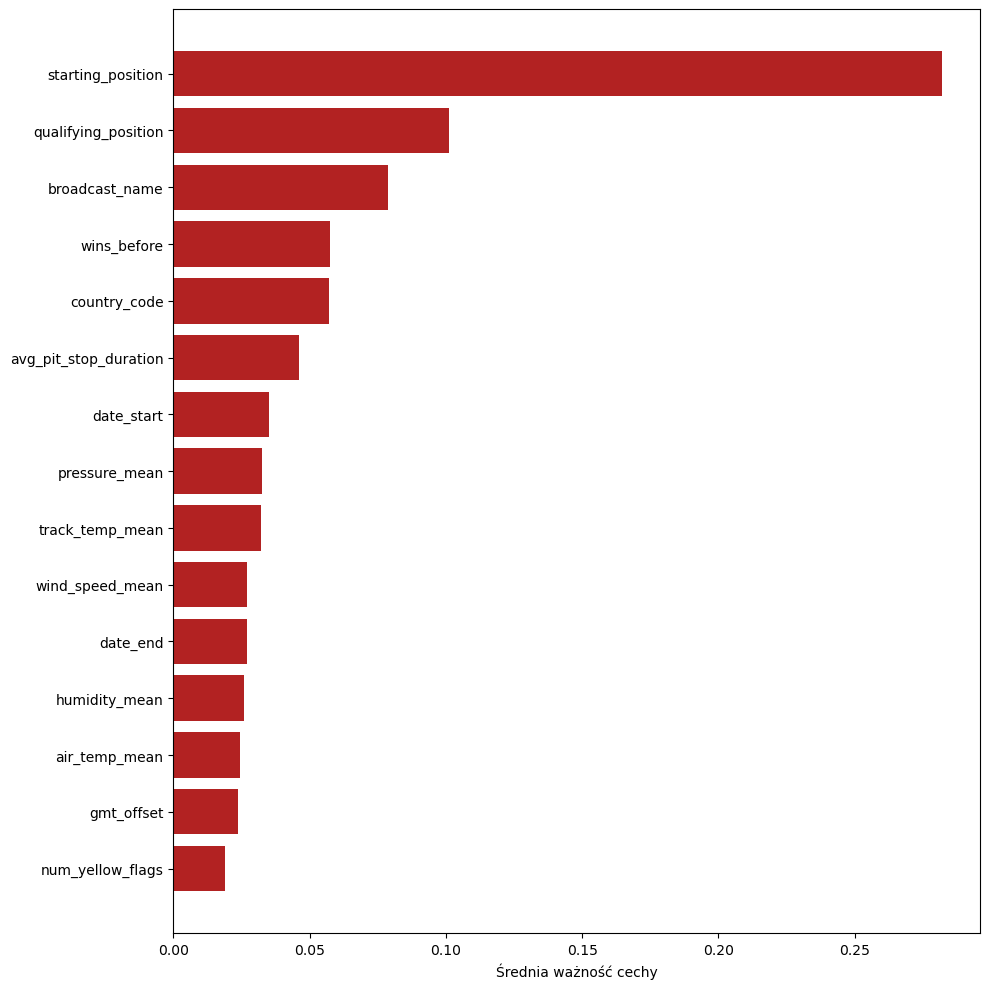

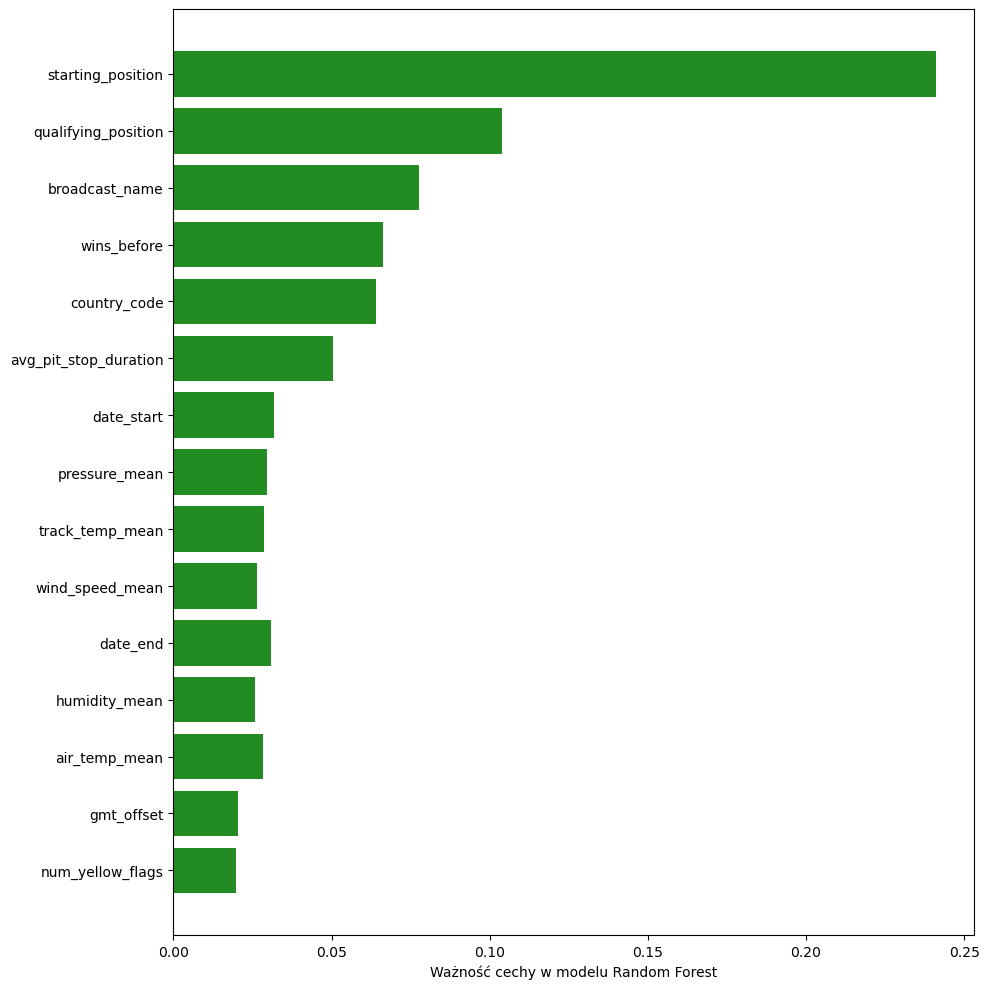

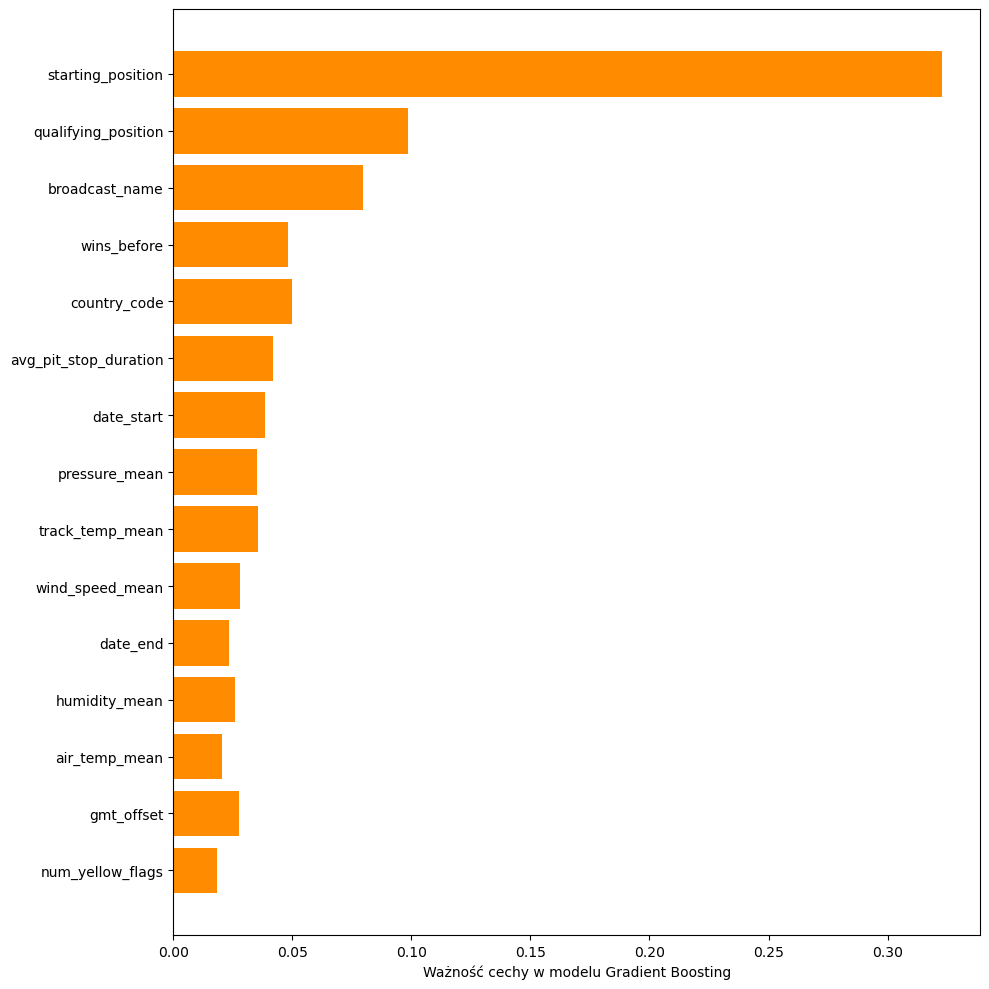

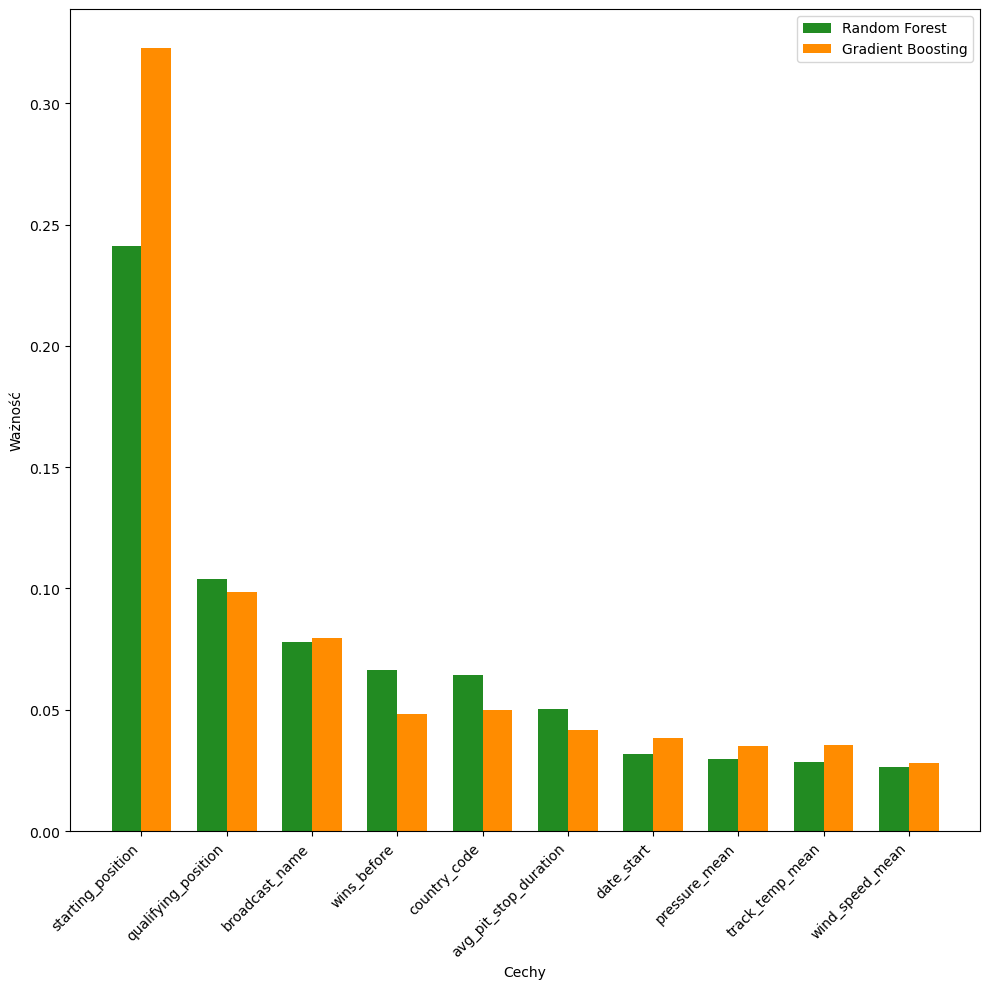


📈 Wszystkie cechy wraz z ich ważnościami:
                    Feature  Random_Forest  Gradient_Boosting  Average
9         starting_position         0.2410             0.3227   0.2819
13      qualifying_position         0.1039             0.0986   0.1012
0            broadcast_name         0.0778             0.0796   0.0787
10              wins_before         0.0664             0.0482   0.0573
1              country_code         0.0642             0.0497   0.0570
12    avg_pit_stop_duration         0.0503             0.0418   0.0461
4                date_start         0.0319             0.0386   0.0352
26            pressure_mean         0.0296             0.0352   0.0324
24          track_temp_mean         0.0285             0.0355   0.0320
28          wind_speed_mean         0.0263             0.0281   0.0272
6                  date_end         0.0308             0.0232   0.0270
25            humidity_mean         0.0257             0.0261   0.0259
23            air_temp_mean       

In [33]:
feature_importance_df = show_feature_importance(study, X_train, y_train, X_train.columns.tolist())

### DODATKOWY MODEL BAZUJACY NA SEKEKCJI CECH

In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectKBest, f_classif

required_features = ['broadcast_name', 'session_name']
other_features = [col for col in X_train.columns if col not in required_features]
selector = SelectKBest(score_func=f_classif, k=8)
X_train_sel = selector.fit_transform(X_train[other_features], y_train)
selected_other = [other_features[i] for i, sel in enumerate(selector.get_support()) if sel]
final_features = required_features + selected_other
X_train_selected = X_train[final_features]
X_valid_selected = X_valid[final_features]

In [35]:
print("Wybrane cechy:", final_features)

Wybrane cechy: ['broadcast_name', 'session_name', 'country_code', 'starting_position', 'wins_before', 'qualifying_position', 'used_soft', 'used_medium', 'used_hard', 'penalty_seconds']


In [36]:
# run the optimization
study_selected = optuna.create_study(direction="maximize")
#trials = 50, kfolds = 5
study_selected.optimize(lambda trial: objective(trial, kfolds=5, X_train=X_train_selected, y_train=y_train, X_valid=X_valid_selected, y_valid=y_valid), n_trials=50)

[I 2025-10-04 19:27:48,767] A new study created in memory with name: no-name-212898b6-bd7d-4d17-b677-525668215adb
[I 2025-10-04 19:27:53,756] Trial 0 finished with value: 0.6486957961836798 and parameters: {'rf_n_estimators': 100, 'rf_max_depth': 7, 'gb_n_estimators': 54, 'gb_learning_rate': 0.12322491992182684, 'gb_max_depth': 3, 'svm_C': 1.267556598339417, 'svm_kernel': 'linear'}. Best is trial 0 with value: 0.6486957961836798.
[I 2025-10-04 19:28:12,034] Trial 1 finished with value: 0.7281190336135518 and parameters: {'rf_n_estimators': 149, 'rf_max_depth': 8, 'gb_n_estimators': 109, 'gb_learning_rate': 0.06483495442200331, 'gb_max_depth': 7, 'svm_C': 1.9458659621792926, 'svm_kernel': 'linear'}. Best is trial 1 with value: 0.7281190336135518.
[I 2025-10-04 19:28:17,838] Trial 2 finished with value: 0.6892841991026672 and parameters: {'rf_n_estimators': 138, 'rf_max_depth': 8, 'gb_n_estimators': 59, 'gb_learning_rate': 0.2119124263647113, 'gb_max_depth': 4, 'svm_C': 0.339590482106801

In [37]:
show_best_parameters_and_metrics(study_selected)

🎯 Najlepsze hiperparametry:
rf_n_estimators: 105
rf_max_depth: 10
gb_n_estimators: 55
gb_learning_rate: 0.29944528292381506
gb_max_depth: 6
svm_C: 1.6605868101720744
svm_kernel: rbf

📊 Metryki najlepszej próby:
F1-score (macro): 0.7444 ± 0.0087
Precision (macro): 0.7627 ± 0.0184
Recall / Sensitivity (macro): 0.7346 ± 0.0154
Specificity (avg): 0.9242 ± 0.0053
Accuracy: 0.8082 ± 0.0083
PR-AUC (macro): 0.7740 ± 0.0250
PR-AUC (weighted): 0.8390 ± 0.0156

🧮 Confusion Matrix:
[[666  71  12   2]
 [ 89 405  30   5]
 [  6  36  99  10]
 [  2  12  14  48]]


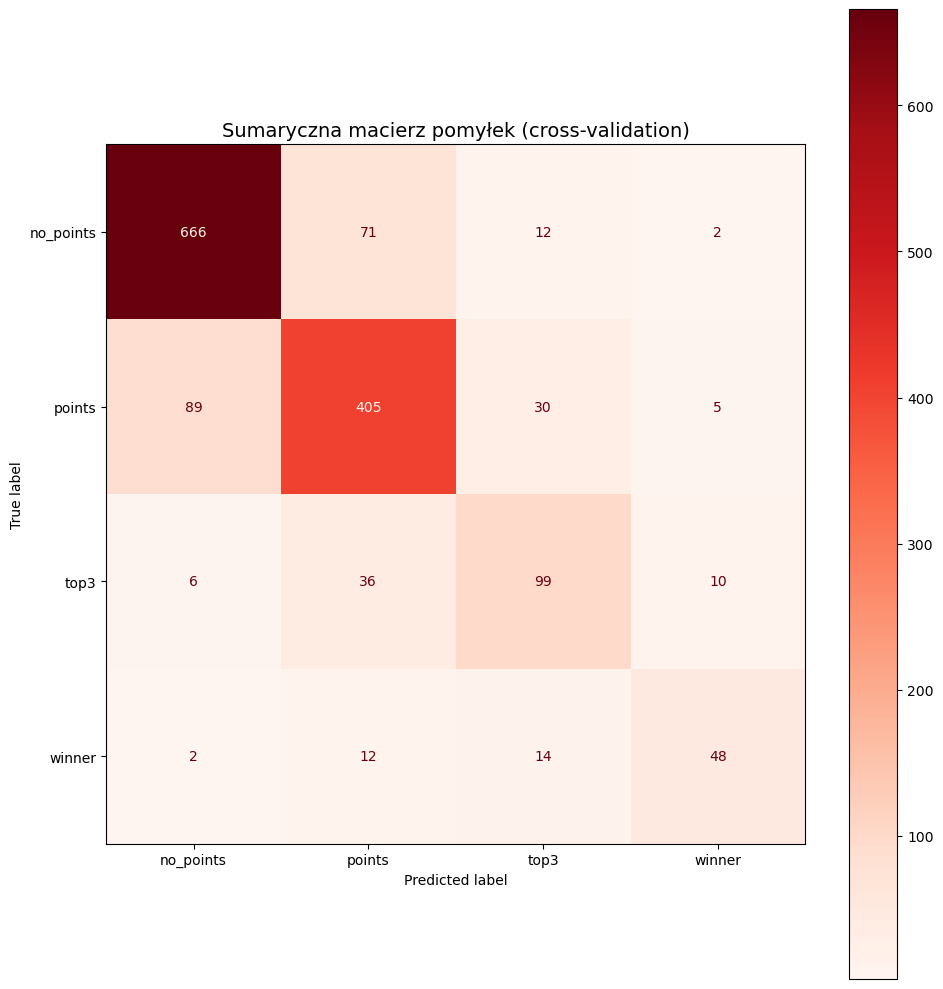

In [38]:
show_confusion_matrix(study_selected)

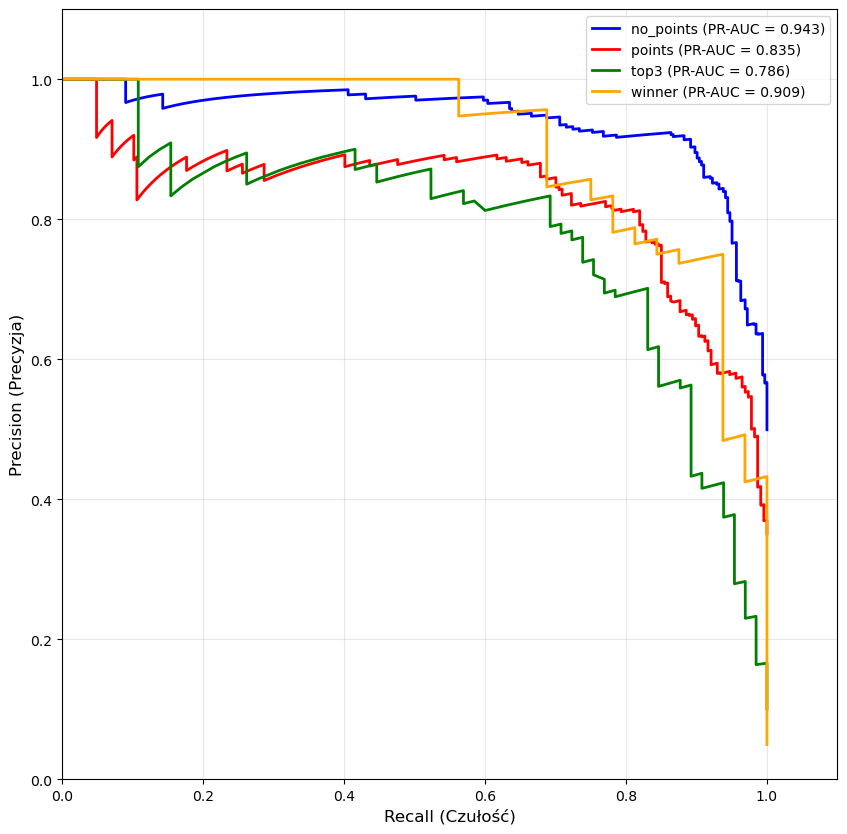

In [53]:
show_pr_auc_plot(study_selected, X_train_selected, y_train, X_valid_selected, y_valid)

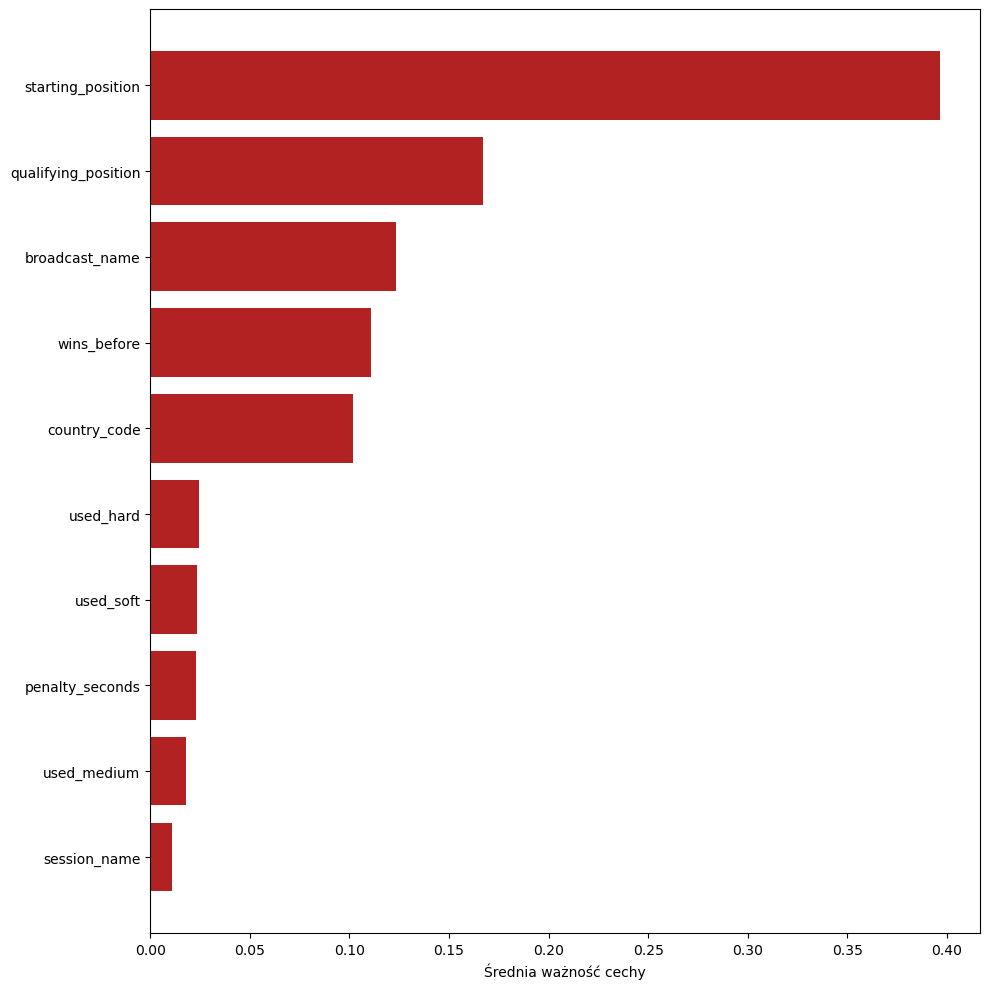

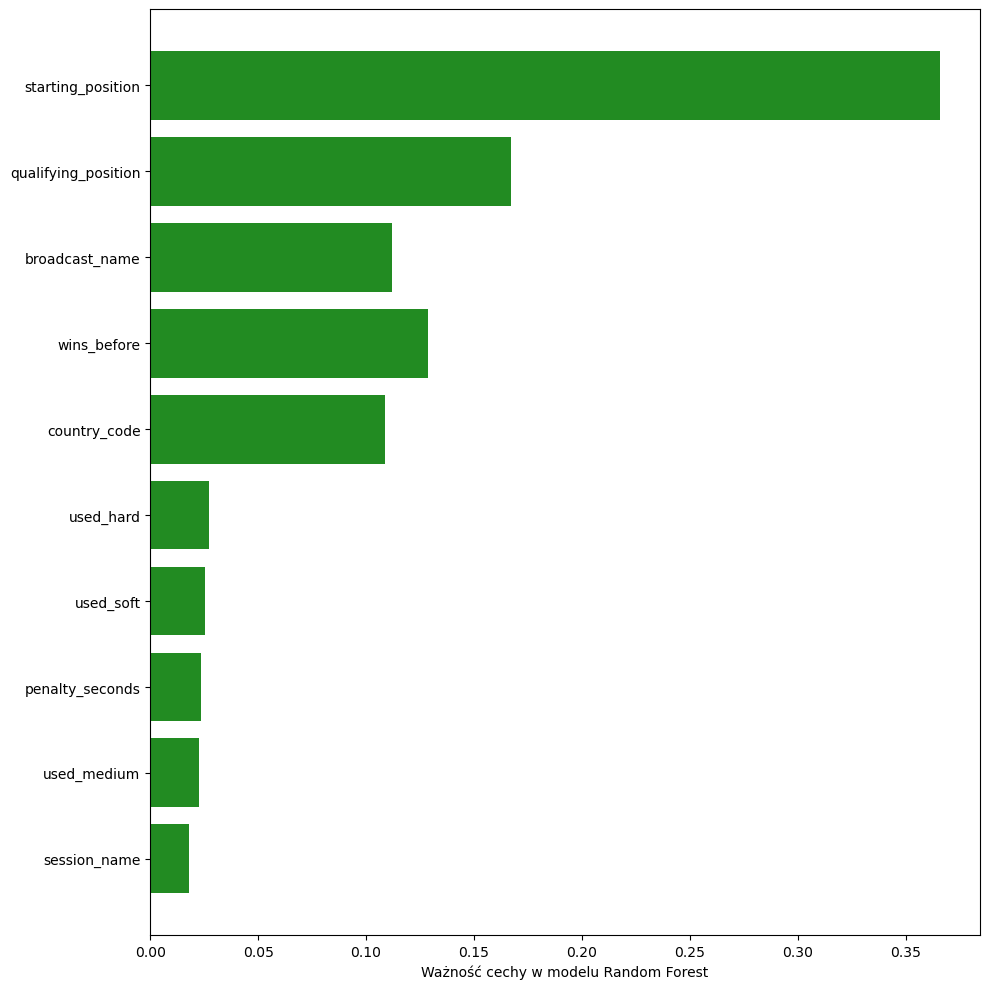

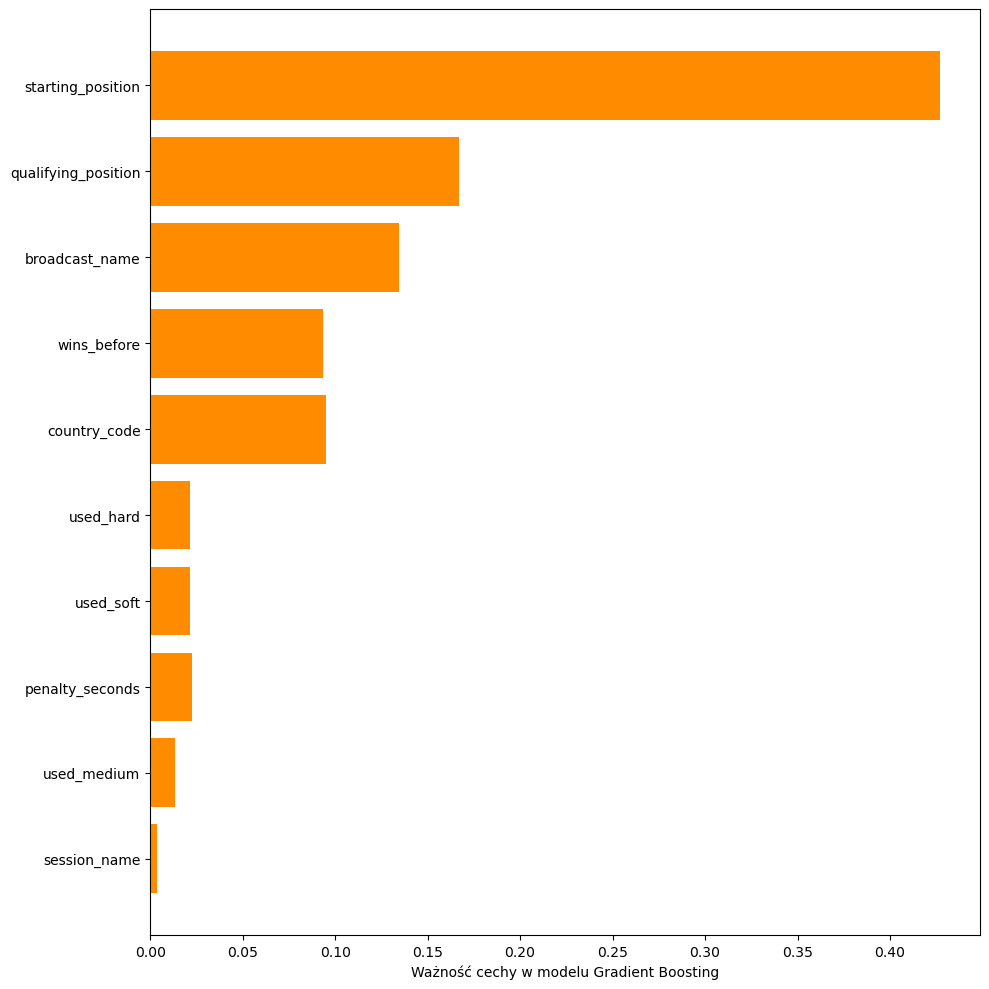

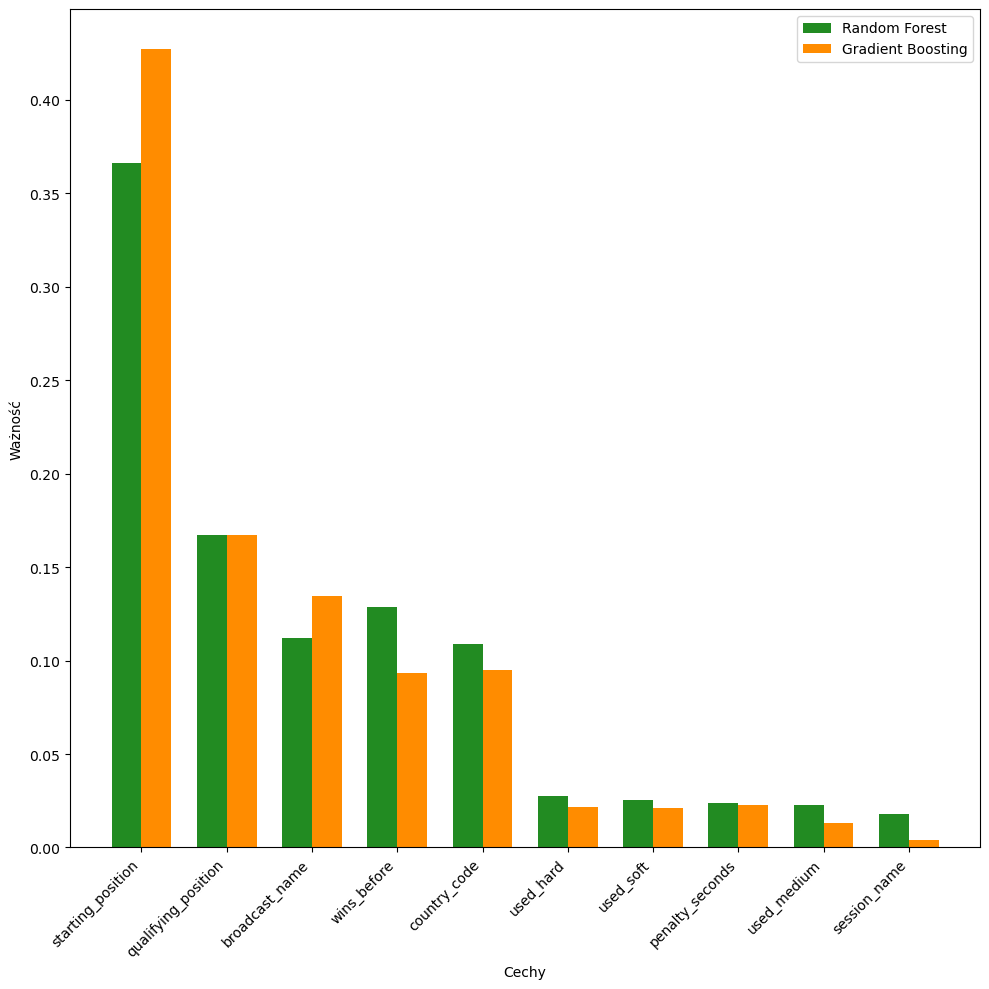


📈 Wszystkie cechy wraz z ich ważnościami:
               Feature  Random_Forest  Gradient_Boosting  Average
3    starting_position         0.3661             0.4273   0.3967
5  qualifying_position         0.1674             0.1672   0.1673
0       broadcast_name         0.1121             0.1345   0.1233
4          wins_before         0.1285             0.0935   0.1110
2         country_code         0.1088             0.0951   0.1019
8            used_hard         0.0274             0.0215   0.0245
6            used_soft         0.0255             0.0213   0.0234
9      penalty_seconds         0.0235             0.0226   0.0231
7          used_medium         0.0228             0.0133   0.0180
1         session_name         0.0179             0.0038   0.0108


In [40]:
feature_importance_selected_df = show_feature_importance(study_selected, X_train_selected, y_train, X_train_selected.columns.tolist())

### RUN OPTUNA FOR 100 ITERATIONS

##### ALL EFATURES

In [41]:
# run the optimization
#study_100 = optuna.create_study(direction="maximize")
#trials = 50, kfolds = 5
#study_100.optimize(lambda trial: objective(trial, kfolds=5, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid), n_trials=100)

In [42]:
#show_best_parameters_and_metrics(study_100)

In [43]:
#show_confusion_matrix(study_100)

In [44]:
#show_pr_auc_plot(study_100, X_train, y_train, X_valid, y_valid)

In [45]:
#feature_importance_100_f = show_feature_importance(study_100, X_train, y_train, X_train.columns.tolist())

##### FEATURE SELECTION

In [46]:
# run the optimization
#study_selected_100 = optuna.create_study(direction="maximize")
#trials = 50, kfolds = 5
#study_selected_100.optimize(lambda trial: objective(trial, kfolds=5, X_train=X_train_selected, y_train=y_train, X_valid=X_valid_selected, y_valid=y_valid), n_trials=100)

In [47]:
#show_best_parameters_and_metrics(study_selected_100)

In [48]:
#show_confusion_matrix(study_selected_100)

In [49]:
#show_pr_auc_plot(study_selected_100, X_train_selected, y_train, X_valid_selected, y_valid)

In [50]:
#feature_importance_100_f = show_feature_importance(study_selected_100, X_train_selected, y_train, X_train_selected.columns.tolist())